In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import itertools

from tqdm import tqdm, trange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from environment import Car, TrafficModel
from util.network import create_braess_network, create_double_braess_network
from util.analysis import plot_social_welfare, plot_travel_time_per_route, plot_cars_per_edge, plot_cars_per_route, draw_edge_utilization, draw_latency_params, \
    plot_latency_increase_per_edge, plot_toll_per_edge, plot_latency_per_edge, plot_summary

## Single Braess

In [ ]:
number_of_cars = 20
number_of_steps = 20

network = create_braess_network(capacity=number_of_cars)
cars = {car_id: Car(car_id, 0, 3, anticipation_strategy='route', verbose=False) for car_id in range(number_of_cars)}

model = TrafficModel(network, cars, R=0.1, beta=1)

model.set_edge_restriction((1, 2), allowed=True)
step_stats, car_stats = model.run_single_steps(number_of_steps)

In [ ]:
plot_summary(model, step_stats, car_stats)

In [ ]:
plot_social_welfare(step_stats)

In [ ]:
plot_travel_time_per_route(car_stats)

In [ ]:
plot_cars_per_edge(car_stats)

In [ ]:
plot_cars_per_route(car_stats)

In [ ]:
plot_latency_per_edge(step_stats)

In [ ]:
plot_toll_per_edge(step_stats)

In [ ]:
draw_edge_utilization(model, car_stats)

In [ ]:
plot_latency_increase_per_edge(model, step_stats)

In [ ]:
draw

## Double Braess

In [ ]:
import itertools

options = itertools.product([(0, 3), ('A', 'B')], [True, False], [True, False])

for (s, t), zero_two_open, one_two_open in options:
    number_of_cars = 20
    number_of_steps = 20

    network = create_double_braess_network(capacity=number_of_cars)
    cars = {car_id: Car(car_id, s, t, anticipation_strategy='route', verbose=False) for car_id in range(number_of_cars)}

    model = TrafficModel(network, cars, R=0.1, beta=1)

    model.set_edge_restriction((0, 2), allowed=zero_two_open)
    model.set_edge_restriction((1, 2), allowed=one_two_open)
    step_stats, car_stats = model.run_single_steps(number_of_steps)

    print(f'{s=}, {t=}, {zero_two_open=}, {one_two_open=}, welfare={(-step_stats["travel_time"]).mean(axis=1).mean()}')

In [ ]:
number_of_cars = 20
number_of_steps = 20

network = create_double_braess_network(capacity=number_of_cars)
cars = {car_id: Car(car_id, 'A', 'B', anticipation_strategy='route', verbose=False) for car_id in range(number_of_cars)}

model = TrafficModel(network, cars, R=0.1, beta=1)

model.set_edge_restriction((0, 2), allowed=True)
model.set_edge_restriction((1, 2), allowed=False)
step_stats, car_stats = model.run_single_steps(number_of_steps)

In [ ]:
(-step_stats["travel_time"]).mean(axis=1).mean()

In [ ]:
plot_social_welfare(step_stats)

In [ ]:
plot_cars_per_route(car_stats)

In [ ]:
plot_latency_per_edge(step_stats)

In [ ]:
plot_latency_increase_per_edge(model, step_stats)

### Find optimum capacity

In [35]:
options = list(itertools.product([(0, 3), ('A', 'B')], [True, False], [True, False]))

results = []
for capacity in trange(2, 40):
    result = []
    
    for (s, t), zero_two_open, one_two_open in options:
        number_of_cars = 20
        number_of_steps = 20

        network = create_double_braess_network(capacity=capacity)
        cars = {car_id: Car(car_id, s, t, anticipation_strategy='route', verbose=False) for car_id in range(number_of_cars)}

        model = TrafficModel(network, cars, R=0.1, beta=1)

        model.set_edge_restriction((0, 2), allowed=zero_two_open)
        model.set_edge_restriction((1, 2), allowed=one_two_open)
        step_stats, car_stats = model.run_single_steps(number_of_steps)

        result.append((-step_stats["travel_time"]).mean(axis=1).mean())

    results.append(result)

results = pd.DataFrame(results, columns=options)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 38/38 [00:12<00:00,  3.13it/s]


<Axes: >

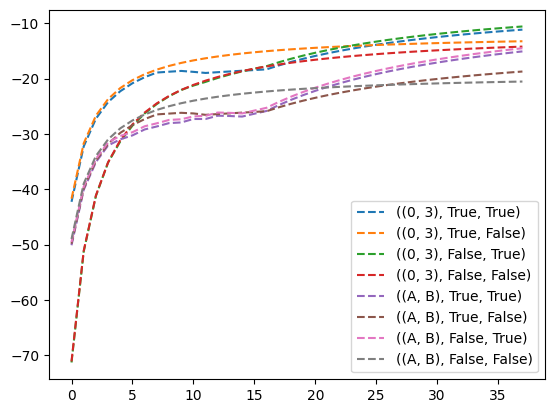

In [50]:
(results + np.linspace(0, 2, 8)).plot(style='--')

<Axes: >

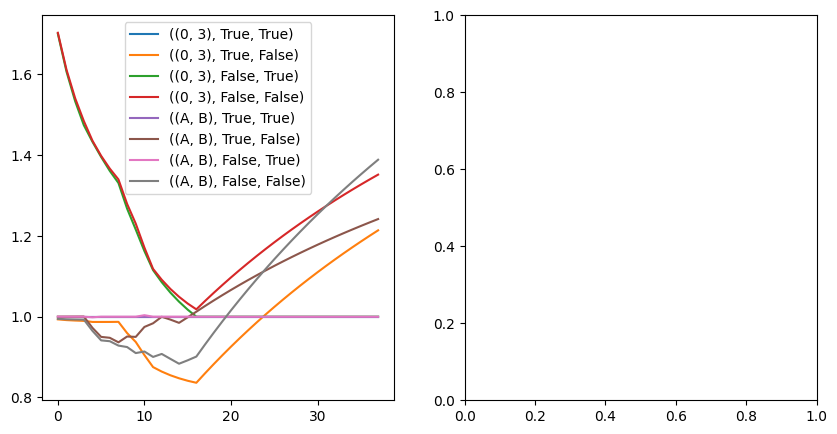

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
results.iloc[:, :4].div(results.iloc[:, 0], axis='index').plot(ax=ax1)
results.iloc[:, 4:].div(results.iloc[:, 4], axis='index').plot(ax=ax1)

# Comparison of configurations

In [14]:
"""A configuration includes:
- Domain
- Number of steps
- Number of cars
- Capacity
- Closed edges
"""

def run(configurations):
    results = []
    for configuration in tqdm(configurations):
        # Set up and run experiment with given configuration

        network = configuration['network'](capacity=configuration['capacity'])
        cars = {car_id: Car(car_id, 0, 3, anticipation_strategy='route', verbose=False) for car_id in range(configuration['number_of_cars'])}

        model = TrafficModel(network, cars, R=0.1, beta=1)

        for edge in configuration.get('closed_edges', []):
            model.set_edge_restriction(edge, allowed=False)

        step_stats, car_stats = model.run_single_steps(number_of_steps)
        result = {'step_stats': step_stats, 'car_stats': car_stats}

        results.append({'configuration': configuration, 'result': result})

    return results

In [18]:
configurations = [
    {'network': create_braess_network, 'number_of_steps': 20, 'number_of_cars': 20, 'capacity': 20, 'closed_edges': []},
    {'network': create_braess_network, 'number_of_steps': 20, 'number_of_cars': 20, 'capacity': 20, 'closed_edges': [(1, 2)]}
]

results = run(configurations)

mean_travel_times = [-result['result']['car_stats']['travel_time'].mean() for result in results]

mean_travel_times

100%|██████████| 2/2 [00:00<00:00, 29.46it/s]


[-17.0, -15.0]